# Assignment 1: Patterns and Similarity

This is a light-weight assignment to warm you up for following coding exercises. In this assignment, you will load a real-world dataset, execute a few code blocks, and explore the outputs. Through this assignment, you are expected to observe how patterns can be used to characterize certain properties of a data object, how they can be used to build a classifier, and how the similarity between data objects can be used to reveal the clustering structure behind the data. 

Let us look at a dataset where the objects of interest are 14 programming languages. The data is formated so that every column corresponds to a "pattern" about GitHub users who use these programming languages.  To make it more fun, each pattern here is an emoji that programmers use in their issue reports and comments.  Every row of the data corresponds to one of the 14 languages, which consists of the counts of each pattern (emoji) that appeared in the GitHub projects with that language as the primary programming language. 

The following snippet loads the data into a numpy array (x) and maps the names of each programming language to a row index (cidx) and each emoji pattern to a column index (fidx).  Now you may check how many times a given emoji pattern (e.g., "🎉") appears in a given programming language (e.g., "Python").  This pattern alone could tell us some characteristics about the language (or how much the programmers like the language), couldn't it?

In [1]:
import csv
import numpy as np

filename = 'assets/language_emoji_distri_label.txt'

with open(filename) as f:
    data = csv.reader(f, delimiter='\t')
    data = list(data)
    data = np.array(data)

colnames = data[0, 1:]
rownames = data[1:, 0]
x = data[1:, 1:]
x = x.astype(float)

fidx = {}
for i in range(colnames.size):
    fidx[colnames[i]] = i

cidx = {}
for i in range(rownames.size):
    cidx[rownames[i]] = i

print('Object names:', rownames.tolist())
print('Pattern names (top 10):', colnames[1:11])
print('Dimensions of data: ', x.shape)
print('How many times pattern {} appears for {}?'.format('🎉', 'Python'), x[cidx['Python'], fidx['🎉']])

Object names: ['C#', 'C', 'VimL', 'R', 'Python', 'Ruby', 'C++', 'PHP', 'CSS', 'Go', 'Java', 'JavaScript', 'Perl', 'Shell']
Pattern names (top 10): ['😄' '😉' '✅' '✔' '🎉' '💯' '❤' '👎' '😃' '⚠']
Dimensions of data:  (14, 1271)
How many times pattern 🎉 appears for Python? 417.0


Now that we obtained patterns that represent the characteristics of each programming language, we can utilize them to deliver more powerful data mining functionalities.  One common practice is to use the patterns as "features" for a downstream machine learning task, such as classification.  For example, suppose developers of a GitHub project use emojis "😄, 👊, and 💃" to describe their experience. Which languages are they more likely to be using? Here, every language is interpreted as a "class" and we will assign a new data object ['😄', '👊', '💃'] into the most likely classes. 

To do that, we need to build a so-called "classifier", which is trained using the observed data objects and their pattern/feature vectors. The trained classifier then takes the input of any new pattern/feature vector and outputs its predictions (a ranked list of classes).  We have implemented a very simple classifier for you, and you will see many more complex classifiers in the supervised machine learning class. 

In [2]:
from collections import namedtuple

# The following functions train a classifier and use the trained classifier to predict the class label of a new input data record
# You don't need to understand the details in the two functions. 

def naive_bayes_train(x, classes, features):
    # a very simple naive Bayes classifier 
    # data input: each row is the accumulated feature vector of a class
    # do not use this function when you have access to individual data examples
    x = x + 0.5 
    rowsum = x.sum(axis = 1)
    x = x / rowsum[:,None]
    rowsum = rowsum / rowsum.sum()
    Model = namedtuple('model', 'pxc pc classes features')
    return( Model(x, rowsum, classes, features) )

def naive_bayes_test(model, x):
    res = np.zeros(model.pc.size, dtype={'names':('class', 'logprob'), 'formats':('S10', 'float')})
    res['class'] = model.classes
    res['logprob'] = np.log(model.pc)
    for i in range(len(x)):
        if x[i] > 0:
            for j in range(len(res)):
                res['logprob'][j] = res['logprob'][j] + x[i] * np.log(model.pxc[j, i])
    return(res)


In [3]:
# Training the model with labeled data (x)
model = naive_bayes_train(x, classes=rownames, features=colnames)

# Classify a new data example, represented as a set of patterns (pattern)
xx = np.zeros(model.features.size)
pattern = ['😄', '👊', '💃']

# Reshape the set into a binary vector

for p in pattern:
    xx[fidx[p]] = 1

# Output the most likely classes. 
prediction = naive_bayes_test(model, xx)
prediction = np.sort(prediction, order='logprob')
topclass = prediction[::-1][0:3]

print('Input patterns:', pattern)
print('Most likely language: ', topclass[0][0].astype(str))
print('Second likely language: ', topclass[1][0].astype(str))
print('Third likely language: ', topclass[2][0].astype(str))

Input patterns: ['😄', '👊', '💃']
Most likely language:  Python
Second likely language:  JavaScript
Third likely language:  C#


Do the results make sense to you?  Given the semantics of the three emojis, "😄(happy), 👊(powerful), 💃(dancing)", do you feel good about having Python as the programming language for MADS? 😄😄 You can also try to predict the most likely languages for a different set of pattern, say "❌, 🐛, and 🚀". Do you still see Python among the top 3 classes?  Do you feel even better? 

### Exercise 1 (10 pts)

Complete the following code block to find the most likely language based on the pattern "['❌', '🐛', '🚀']". Note that you should use the `naive_bayes_test` function in your code block to obtain the result rather than hard-code the answers to the `most_likely_language` variable.

In [4]:
new_pattern = ['❌', '🐛', '🚀']



for p in new_pattern:
    xx[fidx[p]] = 1

# Output the most likely classes. 
prediction = naive_bayes_test(model, xx)
prediction = np.sort(prediction, order='logprob')
topclass = prediction[::-1][0:1]

print('Input patterns:', new_pattern)
print('Most likely language: ', topclass[0][0].astype(str))

most_likely_language = topclass[0][0].astype(str)


Input patterns: ['❌', '🐛', '🚀']
Most likely language:  JavaScript


In [5]:
# This code block contain hidden test for Exercise 1
# We will assess whether you get the correct value for most_likely_language


We've shown that "patterns" of data objects can be utilized to build more complex data mining functionalities.  So can similarities/distances.  In the following example, you'll see how we compute the distance between every pair of our data objects (programming languages), and how we can cluster them purely based on the distances.  The following snippet should generate a hierarchy of languages, where more similar languages (based on how people describe them with emojis) are clustered close by.  This structure of hierarchical clusters are called a "dendrogram."  Does it make sense to you that Javascript is closer to Ruby and Python is closer to Java?  

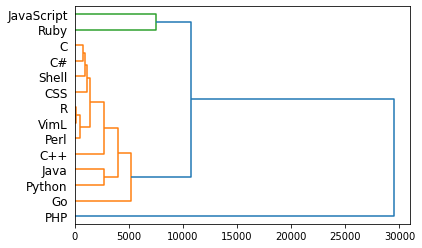

In [6]:
from scipy.cluster import hierarchy
from scipy.spatial import distance
import matplotlib.pyplot as plt
%matplotlib inline

# compute the distances between every pairs of languages
dist = distance.pdist(x, 'euclidean')

# then use the distances to discover the clustering structure
Z = hierarchy.linkage(dist, 'ward')

dn = hierarchy.dendrogram(Z, labels = rownames, orientation='right', color_threshold = 10000)
# this should genereate a hierarchy that shows which languages are closer to which

### Exercise 2 (10 pts)
Based on the dengdrogram above, can you conclude which language is closest to Javascript? Please change the value of the `closest_language` variable in the code block below to indicate your answers. For example, you may replace `""` with `"Java"`.

In [7]:
# print(rownames)

# Change closest_language to the correct value
closest_language = "Ruby"